In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("../../thesis-style.mpl")

In [2]:
    ssp_legend = {'family': 'Source Code Pro',
            'weight': 'normal',
            'size': 8,
            }

In [3]:
import thesis
def thesisify(f, height=1):
    from matplotlib import rc, font_manager
    lato = {'family': 'Lato',
            'color':  'black',
            'weight': 'light',
            'size': 10,
            }
    ssp_ticks = {'family': 'Source Code Pro',
            'weight': 'normal',
            'size': 6,
            }
    ssp_legend = {'family': 'Source Code Pro',
            'weight': 'normal',
            'size': 8,
            }
    ticks_font = font_manager.FontProperties(**ssp_ticks)
    # make the figure look the correct size
    f.set_figwidth(thesis.figwidth)
    f.set_figheight(height * thesis.figheight)
    # individual axis manipulations
    for ax in f.axes:
        for label in ax.get_xticklabels():
            label.set_fontproperties(ticks_font)
        ax.set_xlabel(ax.get_xlabel(), fontdict=lato)  
        ax.xaxis.get_offset_text().set_fontproperties(ticks_font)
        for label in ax.get_yticklabels():
            label.set_fontproperties(ticks_font)
        ax.set_ylabel(ax.get_ylabel(), fontdict=lato) 
        ax.yaxis.get_offset_text().set_fontproperties(ticks_font)
        
        if len(ax.get_ygridlines()) > 0:
            ax.grid(which="both", color='#348ABD', alpha=0.4, lw=0.3,)
        
    f.tight_layout()
    return f

In [4]:
import numpy as np

In [5]:
import elk.catalogue

/home/daniel/.virtualenvs/IGRlaptop21/thesis/lib/python2.7/site-packages/h5py-2.7.0-py2.7-linux-x86_64.egg/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
catalogue = elk.catalogue.NRCatalogue(origin="GeorgiaTech")

In [7]:
query_table = catalogue.table.query( "spin_1x == 0 & spin_1y == 0 & spin_1z == 0"
            " & spin_2x == 0 & spin_2y == 0 & spin_2z == 0")

In [8]:
query_waveforms = [waveform for waveform in catalogue.waveforms if waveform.tag in list(query_table['tag'])]

In [9]:
query_waveforms[:3]

[<NR Waveform GT0760 at q=0.303030298996>,
 <NR Waveform GT0371 at q=0.76923072432>,
 <NR Waveform GT0780 at q=0.263157906894>]

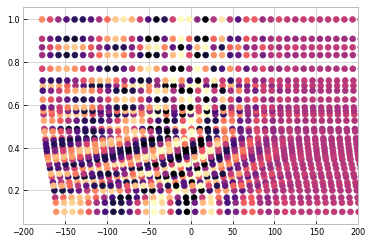

In [12]:
X = []
Y = []
for waveform in query_waveforms:
    ts = waveform.timeseries(60, flow=95, sample_rate=1024, coa_phase=.5)[0]
    #ts.times -= ts.times[np.argmax((ts.data))]
    
    x = np.array([ts.times[ts.times<50],waveform.mass_ratio*np.ones(len(ts.times[ts.times<50]))])
    y = np.array(ts.data[ts.times<50])
    
    X.append(x)
    Y.append(y)
    plt.scatter(x = ts.times*1e4, y= waveform.mass_ratio*np.ones(len(ts.times)), c = ts.data)
    
    plt.xlim([-200, 200])

In [13]:
X = np.atleast_2d(np.hstack(X[:10]))
Y = np.hstack(Y[:10])*1e19

In [14]:
import pymc3 as pm

In [16]:
#X = x[(0),:5000][::,None]#.T
#Y = y[:5000]

with pm.Model() as model:
    
    amp_t = pm.Uniform("amplitude_time", 1, 15)
    #amp_q = pm.Uniform("amplitude_q", 1, 15)
    ls_t =  pm.Uniform("time", 0, .1) #pm.Gamma("metric_time", alpha=3, beta=0.5)
    ls_q = pm.Uniform("metric_q", 0,.1)#pm.Gamma("metric_q", alpha=3, beta=0.5)
    #ls_L = pm.Uniform("metric_L", 0,1, shape=3)
    # Specify the covariance function.
    
    cov_func = pm.gp.cov.ExpQuad(1, active_dims=[0], ls=0.1) * pm.gp.cov.ExpQuad(2, active_dims=[1], ls=0.01) #* pm.gp.cov.ExpQuad(3, active_dims=(8,9,10), ls=ls_L)

    
    gp = pm.gp.Marginal(cov_func=cov_func)
    
    s = pm.Normal("sigma", .00125, 0.1)
    y_ = gp.marginal_likelihood("y", X=X.T, y=Y, noise=0.0001, is_observed=True)

In [ ]:
for q in np.linspace(0.1, 0.9, 10):
    q_new = q * np.ones(400)
    t_new = np.linspace(-0.02,0.1, 400)#[::,None]
    x_new = np.dstack([t_new, q_new])
    #print(x_new[0])
    #mp['time'] = np.array(0.01)
    #mp['time_interval__'] = np.array(.001)
    mu, var = gp.predict(x_new[0], diag=True)
    sd = np.sqrt(var)
    plt.scatter(x = t_new, y= q_new, c = mu)

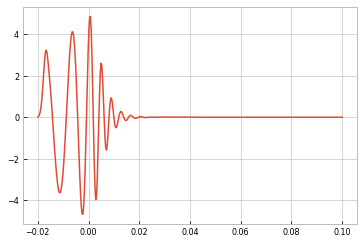